In [1]:
import pandas as pd
import numpy as np

In [2]:
data=pd.read_csv("complaints.csv")
data.head()

C:\Users\Vishal\AppData\Local\Temp\ipykernel_3092\293535195.py:1: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  data=pd.read_csv("complaints.csv")


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2023-10-27,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,Experian Information Solutions Inc.,FL,33181,NaN,NaN,Web,2023-10-27,In progress,Yes,NaN,7766284
1,2023-10-23,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Account information incorrect,NaN,NaN,Self Financial Inc.,CA,92109,NaN,NaN,Web,2023-11-07,Closed with explanation,Yes,NaN,7745570
2,2023-05-04,Debt collection,Credit card debt,Attempts to collect debt not owed,Debt was already discharged in bankruptcy and ...,My personal identifying information was used t...,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,NC,28269,NaN,Consent provided,Web,2023-06-13,Closed with non-monetary relief,Yes,NaN,6928521
3,2023-11-09,Credit reporting or other personal consumer re...,Credit reporting,Improper use of your report,Credit inquiries on your report that you don't...,NaN,NaN,"EQUIFAX, INC.",SC,29486,NaN,NaN,Web,2023-11-09,In progress,Yes,NaN,7825790
4,2023-10-26,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,Experian Information Solutions Inc.,CA,92880,NaN,NaN,Web,2023-10-26,In progress,Yes,NaN,7756715


In [3]:
data.shape

(4280531, 18)

In [4]:
data.isnull().sum()

Date received                         0
Product                               0
Sub-product                      235291
Issue                                 0
Sub-issue                        720492
Consumer complaint narrative    2724597
Company public response         2278899
Company                               0
State                             43516
ZIP code                          30218
Tags                            3842421
Consumer consent provided?       904774
Submitted via                         0
Date sent to company                  0
Company response to consumer          7
Timely response?                      0
Consumer disputed?              3512173
Complaint ID                          0
dtype: int64

In [5]:
data = data.dropna(subset=['Consumer complaint narrative'])

In [6]:
data.isnull().sum()

Date received                         0
Product                               0
Sub-product                       52207
Issue                                 0
Sub-issue                        217594
Consumer complaint narrative          0
Company public response          752061
Company                               0
State                              5707
ZIP code                              0
Tags                            1344953
Consumer consent provided?            0
Submitted via                         0
Date sent to company                  0
Company response to consumer          3
Timely response?                      0
Consumer disputed?              1391900
Complaint ID                          0
dtype: int64

In [7]:
data.Product.unique()

array(['Debt collection', 'Checking or savings account',
       'Credit reporting, credit repair services, or other personal consumer reports',
       'Vehicle loan or lease',
       'Payday loan, title loan, personal loan, or advance loan',
       'Payday loan, title loan, or personal loan',
       'Credit reporting or other personal consumer reports',
       'Student loan', 'Credit card', 'Credit card or prepaid card',
       'Mortgage', 'Prepaid card', 'Debt or credit management',
       'Money transfer, virtual currency, or money service',
       'Credit reporting', 'Bank account or service',
       'Other financial service', 'Payday loan', 'Consumer Loan',
       'Money transfers', 'Virtual currency'], dtype=object)

In [8]:
category_mapping = {
    'Credit reporting or other personal consumer reports': 'Credit reporting, repair or other',
    'Credit reporting, credit repair services, or other personal consumer reports':'Credit reporting, repair or other',
    'Credit reporting':'Credit reporting, repair or other',
    'Checking or savings account':'Credit reporting, repair or other',
    'Debt collection': 'Debt collection',
    'Consumer Loan': 'Consumer Loan',
    'Student loan':'Consumer Loan',
    'Payday loan, title loan, personal loan, or advance loan':'Consumer Loan',
    'Payday loan, title loan, or personal loan':'Consumer Loan',
    'Payday loan':'Consumer Loan',
    'Vehicle loan or lease':'Consumer Loan',
    'Mortgage': 'Mortgage',
    'Money transfer, virtual currency, or money service': 'Credit reporting, repair or other',
    'Prepaid card': 'Credit reporting, repair or other',
    'Credit card or prepaid card': 'Credit reporting, repair or other',
    'Debt or credit management': 'Credit reporting, repair or other',
    'Bank account or service': 'Credit reporting, repair or other',
    'Other financial service': 'Credit reporting, repair or other', 
    'Money transfers': 'Credit reporting, repair or other', 
    'Virtual currency': 'Credit reporting, repair or other',
    'Credit card': 'Credit reporting, repair or other',
}

# Replace categories in the 'Product' column
data['Product'] = data['Product'].replace(category_mapping)

In [9]:
data.Product.unique()

array(['Debt collection', 'Credit reporting, repair or other',
       'Consumer Loan', 'Mortgage'], dtype=object)

In [10]:
data.duplicated().sum()

0

In [12]:
data['Consumer complaint narrative'].head(30)

2      My personal identifying information was used t...
5      I set up a business bank account to transfer f...
14     Consumer Financial Protection Bureau XXXX XXXX...
16     My paycheck comes on Monday or Tuesday night l...
50     Since Wells Fargo is the bank I was approved f...
85     My name is XXXX XXXX XXXX XXXX this complaint ...
124    Vystar Credit Union changed their technology a...
131    On XX/XX/23 at XXXX I made a purchase at XXXX ...
138    AS OF XX/XX/XXXX I HAVE NOTICED FRAUDULENT ACC...
166    Flex needs to update my XXXX credit report inf...
172    HI I AM SUBMITTING THIS WITHOUT ANY INFLUENCE ...
189    Hey I was denied a credit extension through th...
217    Transunion Is in violation of multiple 1970 FC...
222    My credit report is showing late payments to X...
223    I am urging you to take action on these inaccu...
224    In accordance with the Fair Credit Reporting a...
228    The items listed below are reported on my pers...
230    In XXXX I got a car from

In [14]:
data.isnull().sum()

Date received                         0
Product                               0
Sub-product                       52207
Issue                                 0
Sub-issue                        217594
Consumer complaint narrative          0
Company public response          752061
Company                               0
State                              5707
ZIP code                              0
Tags                            1344953
Consumer consent provided?            0
Submitted via                         0
Date sent to company                  0
Company response to consumer          3
Timely response?                      0
Consumer disputed?              1391900
Complaint ID                          0
dtype: int64

In [15]:
data.shape

(1555934, 18)

In [16]:
category_mapping = {
    'Credit reporting, repair or other': 0,
    'Debt collection': 1,
    'Consumer Loan': 2,
    'Mortgage': 3,
}

data['Category'] = data['Product'].map(category_mapping)

In [17]:
data.head(10)

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID,Category
2,2023-05-04,Debt collection,Credit card debt,Attempts to collect debt not owed,Debt was already discharged in bankruptcy and ...,My personal identifying information was used t...,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,NC,28269,NaN,Consent provided,Web,2023-06-13,Closed with non-monetary relief,Yes,NaN,6928521,1
5,2023-09-05,"Credit reporting, repair or other",Savings account,Managing an account,Deposits and withdrawals,I set up a business bank account to transfer f...,Company has responded to the consumer and the ...,SYNCHRONY FINANCIAL,NC,278XX,Older American,Consent provided,Web,2023-09-05,Closed with non-monetary relief,Yes,NaN,7501923,0
14,2023-06-02,"Credit reporting, repair or other",Credit reporting,Incorrect information on your report,Account status incorrect,Consumer Financial Protection Bureau XXXX XXXX...,NaN,"EQUIFAX, INC.",CA,92833,NaN,Consent provided,Web,2023-06-02,Closed with explanation,Yes,NaN,7062166,0
16,2023-09-06,"Credit reporting, repair or other",Other banking product or service,Managing an account,Problem making or receiving payments,My paycheck comes on Monday or Tuesday night l...,NaN,Chime Financial Inc,OK,730XX,NaN,Consent provided,Web,2023-09-06,Closed with explanation,Yes,NaN,7505871,0
50,2023-10-12,Consumer Loan,Loan,Getting a loan or lease,Confusing or misleading advertising or marketing,Since Wells Fargo is the bank I was approved f...,Company has responded to the consumer and the ...,WELLS FARGO & COMPANY,CA,92346,NaN,Consent provided,Web,2023-10-12,Closed with explanation,Yes,NaN,7687998,2
85,2023-08-23,"Credit reporting, repair or other",Credit reporting,Improper use of your report,Reporting company used your report improperly,My name is XXXX XXXX XXXX XXXX this complaint ...,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,MA,021XX,NaN,Consent provided,Web,2023-08-23,Closed with explanation,Yes,NaN,7438622,0
124,2023-10-06,Consumer Loan,Personal line of credit,Charged fees or interest you didn't expect,NaN,Vystar Credit Union changed their technology a...,Company has responded to the consumer and the ...,VYSTAR CREDIT UNION,FL,32207,NaN,Consent provided,Web,2023-10-06,Closed with monetary relief,Yes,NaN,7656847,2
131,2023-09-01,"Credit reporting, repair or other",Checking account,Managing an account,Problem using a debit or ATM card,On XX/XX/23 at XXXX I made a purchase at XXXX ...,NaN,JPMORGAN CHASE & CO.,CA,91761,NaN,Consent provided,Web,2023-09-01,Closed with monetary relief,Yes,NaN,7488677,0
138,2023-07-19,"Credit reporting, repair or other",Credit reporting,Incorrect information on your report,Information belongs to someone else,AS OF XX/XX/XXXX I HAVE NOTICED FRAUDULENT ACC...,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,NY,11550,NaN,Consent provided,Web,2023-07-19,Closed with explanation,Yes,NaN,7273626,0
166,2023-05-31,Consumer Loan,Personal line of credit,Incorrect information on your report,Account information incorrect,Flex needs to update my XXXX credit report inf...,NaN,"Flexible Finance, Inc.",TX,75043,NaN,Consent provided,Web,2023-05-31,Closed with explanation,Yes,NaN,7053643,2


Visualizing to see if data is balanced

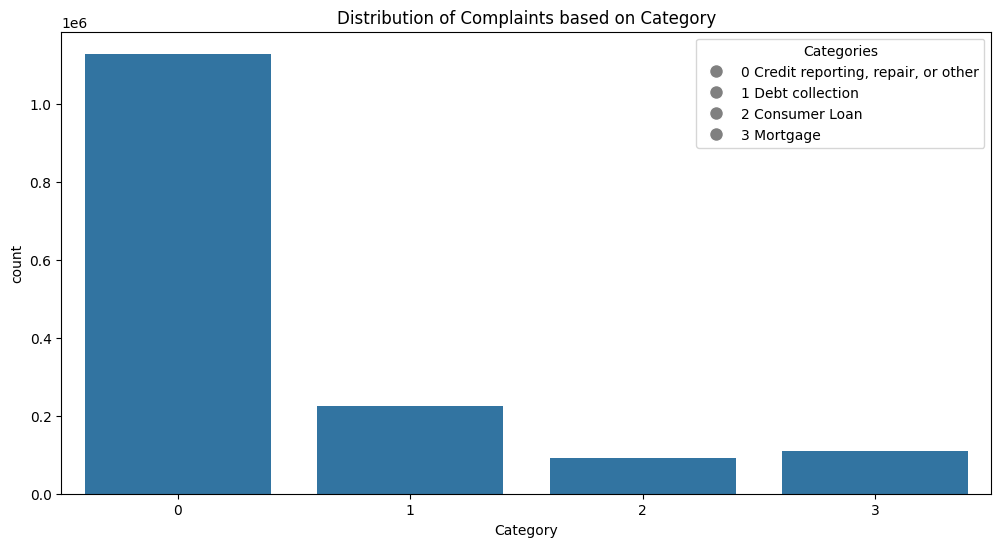

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a vertical count plot
plt.figure(figsize=(12,6))
ax = sns.countplot(x=data['Category'])

# Title
plt.title('Distribution of Complaints based on Category')

# Define legend labels
legend_labels = {
    0: "0 Credit reporting, repair, or other",
    1: "1 Debt collection",
    2: "2 Consumer Loan",
    3: "3 Mortgage"
}

# Create custom legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=10) for _ in legend_labels.values()]
plt.legend(handles, list(legend_labels.values()), title="Categories", loc="upper right")

plt.show()

Need to balance data as we can see its highly imbalanced towards Credit reportiong or others.

In [25]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split

df = pd.DataFrame(data)

# Separate features (X) and target variable (y)
X = df[['Consumer complaint narrative']]
y = df['Category']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Oversample the training data
oversampler = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

# Create a new DataFrame with the resampled data
data_resampled = pd.DataFrame({'Consumer complaint narrative': X_train_resampled['Consumer complaint narrative'], 'Category': y_train_resampled})

# Display the class distribution in the resampled dataset
print("Class distribution after oversampling:\n", data_resampled['Category'].value_counts())

Class distribution after oversampling:
 Category
1    903165
0    903165
2    903165
3    903165
Name: count, dtype: int64


In [30]:
data_resampled.head(20)

,Consumer complaint narrative,Category
0,I have a complaint against Transworld Systems ...,1
1,Chime Bank took about {$7000.00} from my accou...,0
2,In accordance with the Fair Credit Reporting a...,0
3,In 2012 XXXX XXXX XXXXXXXX was forced to forgi...,0
4,"On XX/XX/2021, I sent a letter regarding inacc...",0
5,I attempted to initiate a Credit Freeze with E...,0
6,Since XXXX until now I've reached out multiple...,0
7,I recently refinanced my student loans and pai...,2
8,This is my first endeavor to tell you that I a...,0
9,I have disputed the errors on my credit report...,0


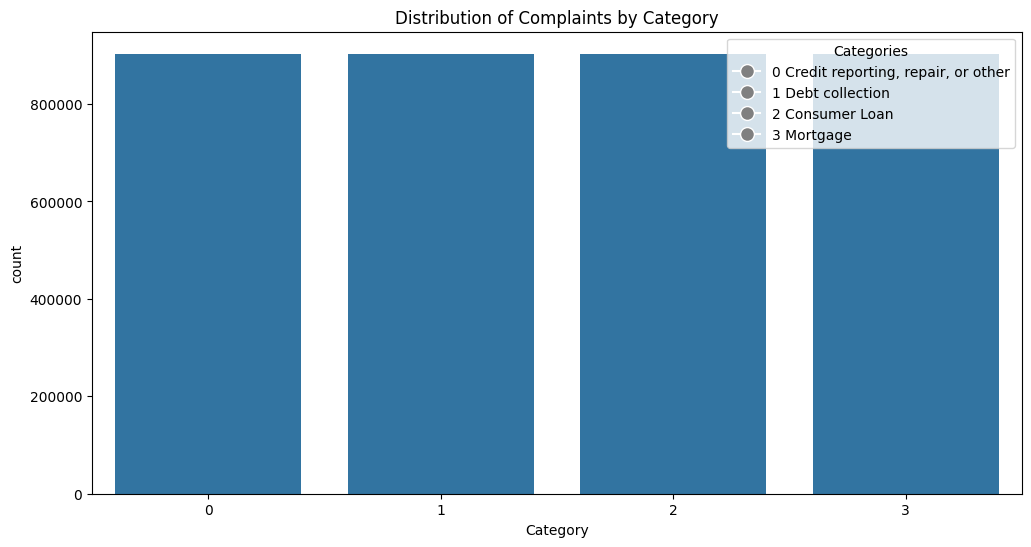

In [31]:
plt.figure(figsize=(12,6))
ax = sns.countplot(x=data_resampled['Category'])

# Add title
plt.title('Distribution of Complaints by Category')

# Define legend labels
legend_labels = {
    0: "0 Credit reporting, repair, or other",
    1: "1 Debt collection",
    2: "2 Consumer Loan",
    3: "3 Mortgage"
}

# Create custom legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=10) for _ in legend_labels.values()]
plt.legend(handles, list(legend_labels.values()), title="Categories", loc="upper right")

plt.show()

Text Pre-processing

In [3]:
import re
import spacy

# Download NLTK resources (stopwords and punkt tokenizer)
nlp_model = spacy.load('en_core_web_sm')

def text_Cleaning(text):
    # Custom regex pattern
    pattern = r'(\d|XXXX|XX/XX/[0-9]{4,4}|[^a-zA-Z0-9_])+'
    text = re.sub(pattern, " ", text)
    text = text.lower().strip()
    doc = nlp_model(text)
    text = ' '.join([token.lemma_ for token in doc if not token.is_stop])

    return text

# Example usage
input_text = "Your example text (XX/XX/2022) here with some XX special tokens. XXXX etc."
cleaned_text = text_Cleaning(input_text)
print(cleaned_text)

OSError: [E050] Can't find model 'en_core_web_sm'. It doesn't seem to be a Python package or a valid path to a data directory.